# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import math

import os
import datetime

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('../Datasets/database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [14]:
reviewDF = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
reviewDF = reviewDF[:100000]

In [15]:
# Saving dataframe to make sure we are processing same dataset(Train, Test, Cv) across various models.
reviewDF.to_pickle('reviewDF')

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [2]:
reviewDF = pd.read_pickle('../Datasets/reviewDF')

In [3]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [5]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
rLength = []
# tqdm is for printing the status bar
for sentance in tqdm(reviewDF['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    rLength.append(len(sentance.split(' ')))

100%|██████████| 100000/100000 [00:45<00:00, 2219.72it/s]


In [6]:
preprocessed_reviews[150]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='../Datasets/train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='../Datasets/train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='../Datasets/confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='../Datasets/summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

In [7]:
#Forming separate datafrmae
Dataset = pd.DataFrame(
    {'Review': preprocessed_reviews,
     'length': rLength,
     'Score' : reviewDF['Score']
    })
X = Dataset.iloc[:,:2].values
Y = Dataset.Score.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 

X_trainText = np.array(X_train[:,:1])
X_trainText = X_trainText.reshape(X_trainText.shape[0],)

X_CVText = np.array(X_cv[:,:1])
X_CVText = X_CVText.reshape(X_CVText.shape[0],)

X_testText  = np.array(X_test[:,:1])
X_testText  = X_testText.reshape(X_testText.shape[0],) 

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [8]:
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10) 
vectorizer.fit(X_trainText)

X_train_bow = vectorizer.transform(X_trainText)
X_train_bow = preprocessing.normalize(X_train_bow)
print("Train Data Size: ",X_train_bow.shape)

X_cv_bow = vectorizer.transform(X_CVText)
X_cv_bow = preprocessing.normalize(X_cv_bow)
print("CV Data Size: ",X_cv_bow.shape)

X_test_bow = vectorizer.transform(X_testText)
X_test_bow = preprocessing.normalize(X_test_bow)
print("Test Data Size:  ",X_test_bow.shape)

Train Data Size:  (44890, 25287)
CV Data Size:  (22110, 25287)
Test Data Size:   (33000, 25287)


#### Linear SVM with L1 regularization

100%|██████████| 9/9 [00:17<00:00,  1.99s/it]


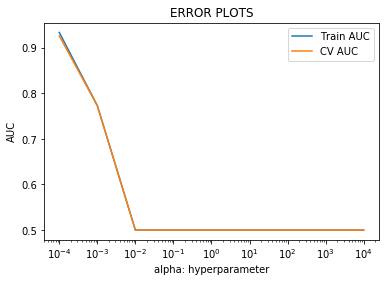

In [12]:
# Model Training
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,9)
for i in tqdm(alpha):
    clf = SGDClassifier(loss='hinge', penalty='l1',alpha=i)
    model = CalibratedClassifierCV(base_estimator=clf ,cv=10)
    model.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [14]:
# Optimal hyperparameter
bestParameter = alpha[cv_auc.index(max(cv_auc))]
print("Optimal_alpha:",bestParameter)

Optimal_alpha: 0.0001


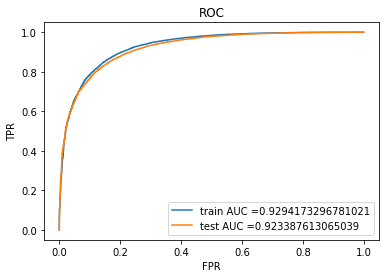

In [15]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l1')
clf.fit(X_train_bow, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_bow, y_train)

predTest  = model.predict_proba(X_test_bow)
predTrain = model.predict_proba(X_train_bow)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

In [16]:
import itertools
def confusionMatrixPlot(YTest, predTest,title):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(YTest, predTest)
    plt.imshow(cnf_matrix,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
#     plt.title('Confusion Matrix')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(YTest))) # length of classes
    class_labels = ['0','1']
    tick_marks
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cnf_matrix.max() / 2.
    for i,j in itertools.product(range(cnf_matrix.shape[0]),range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j],'d'),horizontalalignment='center',color='black' if cnf_matrix[i,j] >thresh else 'black')
    plt.show();

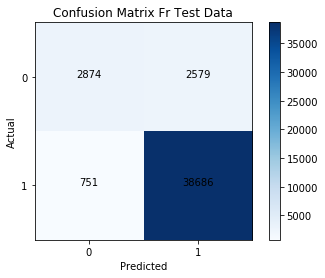

In [18]:
# Confusion Matrix
confusionMatrixPlot(y_train,model.predict(X_train_bow),"Confusion Matrix Fr Test Data")

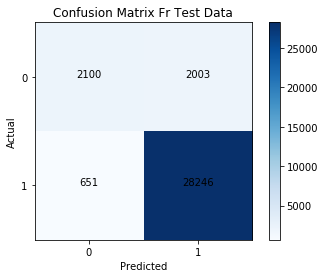

In [17]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_bow),"Confusion Matrix Fr Test Data")

#### Feature Importance

In [69]:
# Please write all the code with proper documentation
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': clf.coef_[0],
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [71]:
# Top 10 positive features
sortedFeature[-15:]

,feature,Probability
1242,awesome,1.936779
14821,not bad,2.005525
16933,pleased,2.079303
25298,yummy,2.183026
20174,smooth,2.184255
12818,loves,2.244760
9563,great,2.279601
19186,satisfying,2.311775
1704,best,2.476351
6825,excellent,2.709484


In [72]:
# Top 10 negative features
sortedFeature[:15]

,feature,Probability
24972,worst,-7.716473
15354,not worth,-7.117361
5607,disappointment,-6.708733
5606,disappointing,-6.267847
10468,horrible,-6.250494
1249,awful,-5.987206
5596,disappointed,-5.817379
22484,terrible,-5.766265
18734,return,-5.322684
15199,not recommend,-5.093689


#### Linear SVM with L2 regularization

100%|██████████| 9/9 [00:14<00:00,  1.77s/it]


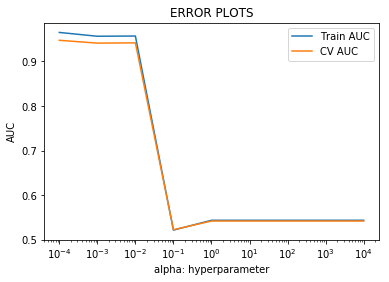

In [19]:
# Model Training
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,9)
for i in tqdm(alpha):
    clf = SGDClassifier(loss='hinge', penalty='l2',alpha=i)
    model = CalibratedClassifierCV(base_estimator=clf ,cv=10)
    model.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [20]:
# Best hyperparameter
bestParameter = alpha[cv_auc.index(max(cv_auc))]
print("Optimal_alpha:",bestParameter)

Optimal_alpha: 0.0001


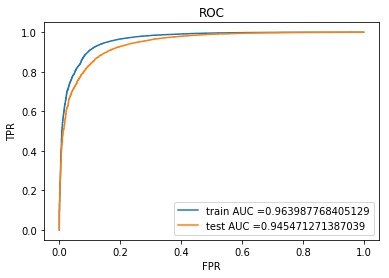

In [21]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l2')
clf.fit(X_train_bow, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_bow, y_train)

predTest  = model.predict_proba(X_test_bow)
predTrain = model.predict_proba(X_train_bow)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

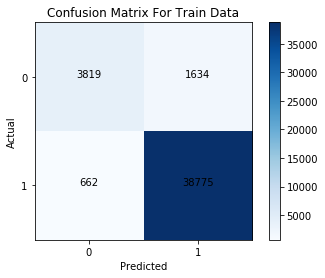

In [23]:
# Confusion Matrix
confusionMatrixPlot(y_train, model.predict(X_train_bow),"Confusion Matrix For Train Data")

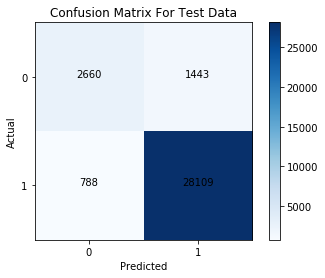

In [22]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_bow),"Confusion Matrix For Test Data")

### Feature Engineering

In [112]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_bow_newF = sparse.hstack((X_train_bow,reviewLen))
X_train_bow_newF = preprocessing.normalize(X_train_bow_newF)

print("Old Dimension: "+str(X_train_bow.shape))
print("New Dimension: "+ str(X_train_bow_newF.shape))

Old Dimension: (44890, 25334)
New Dimension: (44890, 25335)


In [113]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_bow_newF = sparse.hstack((X_test_bow,reviewLen))
X_test_bow_newF = preprocessing.normalize(X_test_bow_newF)
print("Old Dimension: "+str(X_test_bow.shape))
print("New Dimension: "+ str(X_test_bow_newF.shape))

Old Dimension: (33000, 25334)
New Dimension: (33000, 25335)


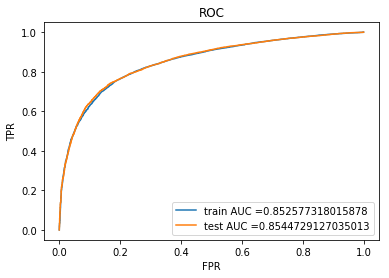

In [116]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l2')
clf.fit(X_train_bow_newF, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_bow_newF, y_train)

predTest  = model.predict_proba(X_test_bow_newF)
predTrain = model.predict_proba(X_train_bow_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

* Observation: Model Accuracy drops after adding review length as a extra feature.

## [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [24]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train_tfidf.shape)

X_cv_tfidf = vectorizer.transform(X_CVText)
X_cv_tfidf = preprocessing.normalize(X_cv_tfidf)
print("CV Data Size:    ",X_cv_bow.shape)

X_test_tfidf = vectorizer.transform(X_testText)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size:  ",X_train_tfidf.shape)

Train Data Size:  (44890, 25287)
CV Data Size:     (22110, 25287)
Test Data Size:   (44890, 25287)


#### Linear SVM with L1 regularization

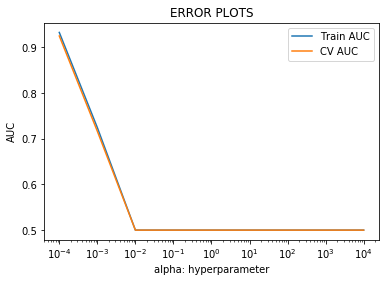

In [25]:
# Model Training
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,9)
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty='l1',alpha=i)
    model = CalibratedClassifierCV(base_estimator=clf ,cv=10)
    model.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [26]:
# Optimal hyperparameter
bestParameter = alpha[cv_auc.index(max(cv_auc))]
print("Optimal_alpha:",bestParameter)

Optimal_alpha: 0.0001


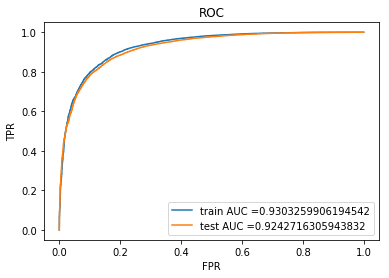

In [27]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l1')
clf.fit(X_train_tfidf, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_tfidf, y_train)

predTest  = model.predict_proba(X_test_tfidf)
predTrain = model.predict_proba(X_train_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

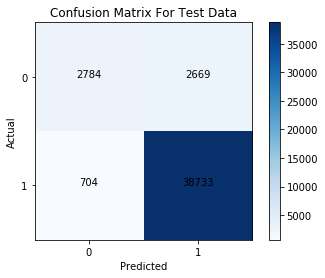

In [30]:
# Confusion Matrix
confusionMatrixPlot(y_train, model.predict(X_train_tfidf),"Confusion Matrix For Test Data")

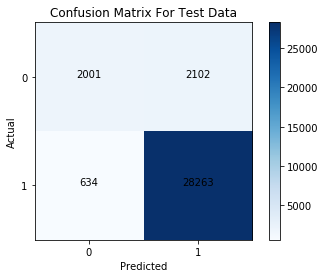

In [29]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_tfidf),"Confusion Matrix For Test Data")

#### Feature Importance

In [126]:
# Please write all the code with proper documentation
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': clf.coef_[0],
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [127]:
# Top 10 positive features
sortedFeature[-15:]

,feature,Probability
22051,tasty,1.994309
12627,love,2.021343
14821,not bad,2.024903
14529,nice,2.045486
12818,loves,2.471521
25298,yummy,2.554894
668,amazing,2.694829
9123,good,2.789342
6825,excellent,2.940597
16641,perfect,2.941250


In [128]:
# Top 10 negative features
sortedFeature[:15]

,feature,Probability
24972,worst,-8.427824
15354,not worth,-6.846232
5596,disappointed,-6.750659
10468,horrible,-5.917256
5606,disappointing,-5.909675
22484,terrible,-5.839929
18734,return,-5.839295
22765,threw,-5.540400
1249,awful,-5.397479
5607,disappointment,-4.830786


#### Linear SVM with L2 regularization

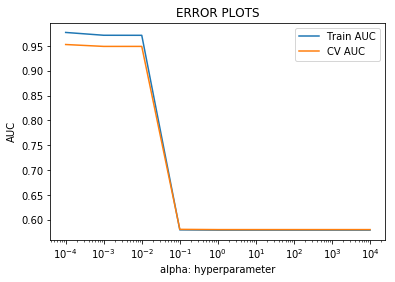

In [31]:
# Model Training
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,9)
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty='l2',alpha=i)
    model = CalibratedClassifierCV(base_estimator=clf ,cv=10)
    model.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [32]:
# Best hyperparameter
bestParameter = alpha[cv_auc.index(max(cv_auc))]
print("Optimal_alpha:",bestParameter)

Optimal_alpha: 0.0001


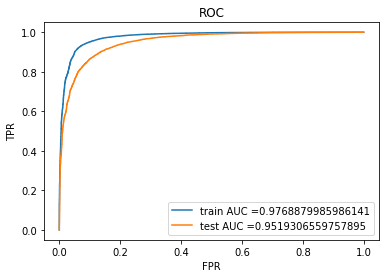

In [33]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l2')
clf.fit(X_train_tfidf, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_tfidf, y_train)

predTest  = model.predict_proba(X_test_tfidf)
predTrain = model.predict_proba(X_train_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

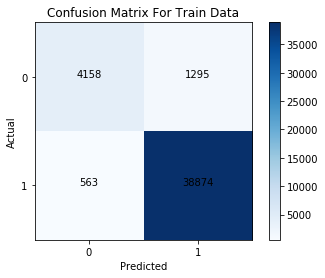

In [36]:
# Confusion Matrix
confusionMatrixPlot(y_train,model.predict(X_train_tfidf),"Confusion Matrix For Train Data")

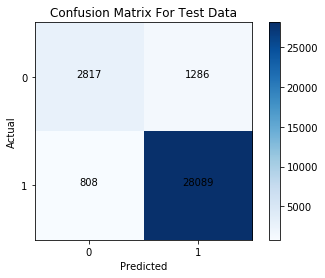

In [35]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_tfidf),"Confusion Matrix For Test Data")

#### Feature Engineering
    - Adding review length as a extra feature.

In [135]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_tfidf_newF = sparse.hstack((X_train_tfidf,reviewLen))
X_train_tfidf_newF = preprocessing.normalize(X_train_tfidf_newF)
print("Old Dimension: "+str(X_train_tfidf.shape))
print("New Dimension: "+ str(X_train_tfidf_newF.shape))

Old Dimension: (44890, 25334)
New Dimension: (44890, 25335)


In [136]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_tfidf_newF = sparse.hstack((X_test_tfidf,reviewLen))
X_test_tfidf_newF = preprocessing.normalize(X_test_tfidf_newF)
print("Old Dimension: "+str(X_test_tfidf.shape))
print("New Dimension: "+ str(X_test_tfidf_newF.shape))

Old Dimension: (33000, 25334)
New Dimension: (33000, 25335)


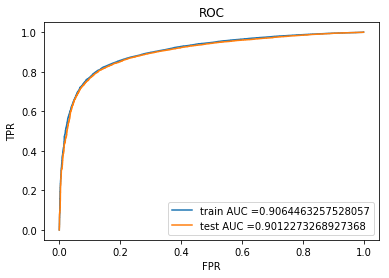

In [137]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l2')
clf.fit(X_train_tfidf_newF, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_bow_newF, y_train)

predTest  = model.predict_proba(X_test_tfidf_newF)
predTrain = model.predict_proba(X_train_tfidf_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

* Observation: Model Accuracy drops after adding review length as a extra feature. But, it is comparitively better than the model trained over BOW vectorizer.

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [37]:
# Train your own Word2Vec model using your own text corpus
def sentenceSplit(data):
    list_of_sentance=[]
    for sentance in data:
        list_of_sentance.append(sentance.split())
    return list_of_sentance

In [38]:
# this line of code trains your w2v model on the give list of sentances
list_of_sentance_train = sentenceSplit(X_trainText)
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=150, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [39]:
def avgW2V(list_of_sentance,W2VModel):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(150) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in W2VModel:
                vec = W2VModel.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [40]:
# Vectorizing Train and Test data
# Training Data
X_train_w2v = avgW2V(list_of_sentance_train, w2v_model)

# CV Data
list_of_sentance_cv = sentenceSplit(X_CVText)
X_cv_w2v = avgW2V(list_of_sentance_cv, w2v_model)

# Test Data
list_of_sentance_test = sentenceSplit(X_testText)
X_test_w2v = avgW2V(list_of_sentance_test, w2v_model)

100%|██████████| 33000/33000 [00:15<00:00, 2186.51it/s]


#### Linear SVM with L1 Regularisation

100%|██████████| 9/9 [00:42<00:00,  5.23s/it]


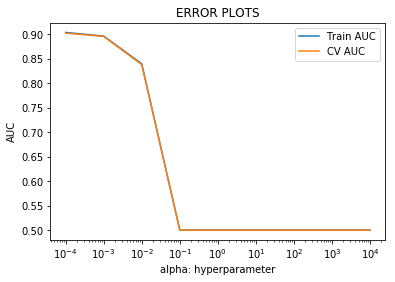

In [41]:
# Model Training
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,9)
for i in tqdm(alpha):
    clf = SGDClassifier(loss='hinge', penalty='l1',alpha=i)
    model = CalibratedClassifierCV(base_estimator=clf ,cv=10)
    model.fit(X_train_w2v, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_w2v)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_w2v)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [42]:
# Best hyperparameter
bestParameter = alpha[cv_auc.index(max(cv_auc))]
print("Optimal_alpha",bestParameter)

Optimal_alpha 0.0001


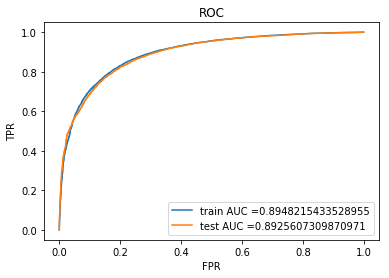

In [44]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l1')
clf.fit(X_train_w2v, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_w2v, y_train)

predTest  = model.predict_proba(X_test_w2v)
predTrain = model.predict_proba(X_train_w2v)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

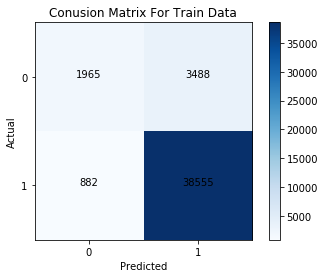

In [46]:
# Confusion Matrix
confusionMatrixPlot(y_train, model.predict(X_train_w2v), "Conusion Matrix For Train Data")

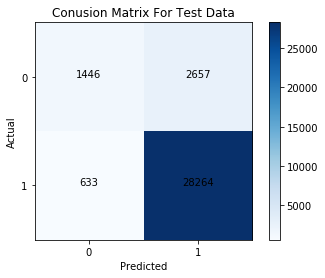

In [45]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_w2v), "Conusion Matrix For Test Data")

#### Linear SVM with L2 Regularisation

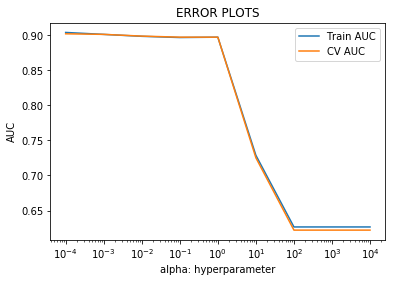

In [47]:
# Model Training
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,9)
for i in alpha:
    clf = SGDClassifier(loss='hinge', penalty='l2',alpha=i)
    model = CalibratedClassifierCV(base_estimator=clf ,cv=10)
    model.fit(X_train_w2v, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_w2v)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_w2v)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [48]:
# Best hyperparameter
bestParameter = alpha[cv_auc.index(max(cv_auc))]
print("Optimal_alpha",bestParameter)

Optimal_alpha 0.0001


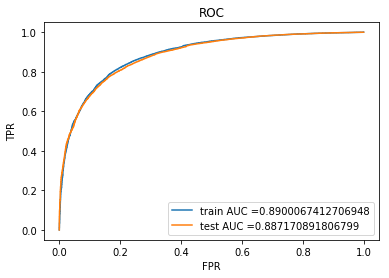

In [50]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l2')
clf.fit(X_train_w2v, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_w2v, y_train)

predTest  = model.predict_proba(X_test_w2v)
predTrain = model.predict_proba(X_train_w2v)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

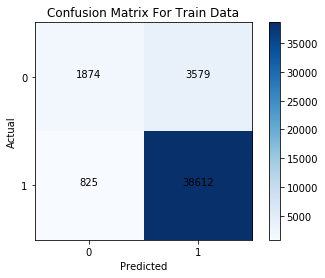

In [52]:
# Confusion Matrix
confusionMatrixPlot(y_train, model.predict(X_train_w2v),"Confusion Matrix For Train Data")

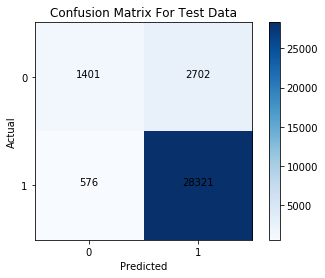

In [51]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_w2v),"Confusion Matrix For Test Data")

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [53]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_trainText:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_testText:
    sent_of_test.append(sent.split()) 
    
sent_of_cv = []
for sent in X_CVText:
    sent_of_cv.append(sent.split())


In [54]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 44890/44890 [25:35<00:00, 29.24it/s]  


In [55]:
# TFIDF-Word2Vec for CV data.
X_cv_tfidf = vectorizer.transform(X_CVText)
X_cv_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_cv): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_cv_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 22110/22110 [12:41<00:00, 28.32it/s]


In [56]:
# TFIDF-Word2Vec for test data .
X_test_tfidf_AW2V = []; 
X_test_tfidf = vectorizer.transform(X_testText)
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 33000/33000 [18:55<00:00, 29.06it/s] 


In [58]:
X_train_tfidf_AW2V = preprocessing.normalize(X_train_tfidf_AW2V)
X_cv_tfidf_AW2V = preprocessing.normalize(X_cv_tfidf_AW2V)
X_test_tfidf_AW2V = preprocessing.normalize(X_test_tfidf_AW2V)

#### Linear SVM with L1 Regularisation

100%|██████████| 9/9 [00:45<00:00,  5.58s/it]


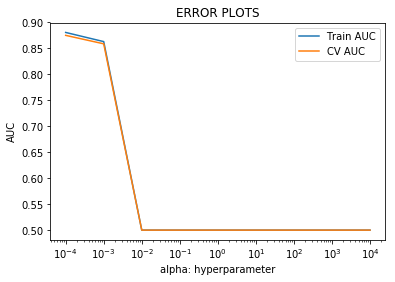

In [59]:
# Model Training
train_auc = []
cv_auc = []#### Linear SVM with L2 Regularisation
alpha = np.logspace(-4,4,9)
for i in tqdm(alpha):
    clf = SGDClassifier(loss='hinge', penalty='l1',alpha=i)
    model = CalibratedClassifierCV(base_estimator=clf ,cv=10)
    model.fit(X_train_tfidf_AW2V, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_tfidf_AW2V)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_tfidf_AW2V)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [60]:
# Best hyperparameter
bestParameter = alpha[cv_auc.index(max(cv_auc))]
print("Optimal_alpha",bestParameter)

Optimal_alpha 0.0001


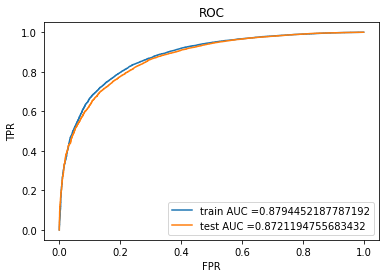

In [61]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l1')
clf.fit(X_train_tfidf_AW2V, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_tfidf_AW2V, y_train)

predTest  = model.predict_proba(X_test_tfidf_AW2V)
predTrain = model.predict_proba(X_train_tfidf_AW2V)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

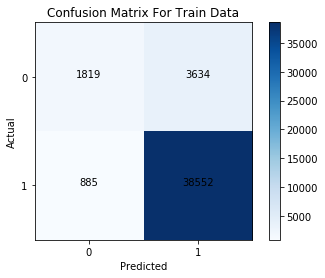

In [63]:
# Confusion Matrix
confusionMatrixPlot(y_train,model.predict(X_train_tfidf_AW2V), "Confusion Matrix For Train Data")

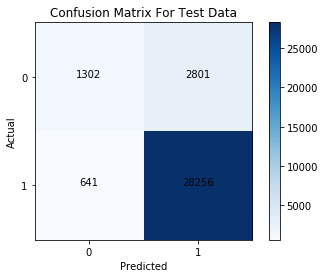

In [62]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_tfidf_AW2V), "Confusion Matrix For Test Data")

#### Linear SVM with L2 Regularisation

100%|██████████| 9/9 [00:29<00:00,  3.49s/it]


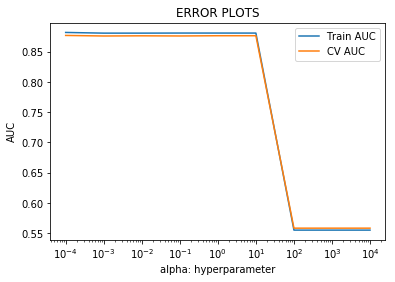

In [64]:
# Model Training
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,9)
for i in tqdm(alpha):
    clf = SGDClassifier(loss='hinge', penalty='l2',alpha=i)
    model = CalibratedClassifierCV(base_estimator=clf ,cv=10)
    model.fit(X_train_tfidf_AW2V, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_tfidf_AW2V)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_tfidf_AW2V)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [65]:
# Best hyperparameter
bestParameter = alpha[cv_auc.index(max(cv_auc))]
print("Optimal_alpha",bestParameter)

Optimal_alpha 0.0001


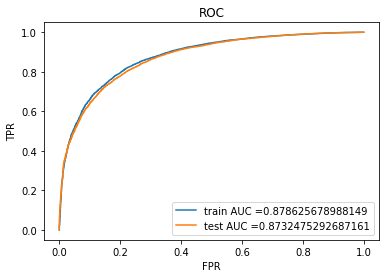

In [66]:
# Testing accuracy on test dataset
clf = SGDClassifier(loss='hinge' ,alpha=bestParameter, penalty='l2')
clf.fit(X_train_tfidf_AW2V, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_tfidf_AW2V, y_train)

predTest  = model.predict_proba(X_test_tfidf_AW2V)
predTrain = model.predict_proba(X_train_tfidf_AW2V)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

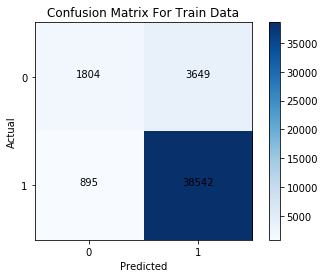

In [69]:
# Confusion Matrix
confusionMatrixPlot(y_train, model.predict(X_train_tfidf_AW2V), "Confusion Matrix For Train Data")

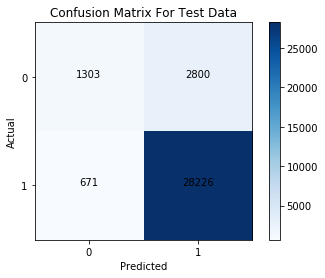

In [67]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_tfidf_AW2V), "Confusion Matrix For Test Data")

## [5.2] RBF SVM

In [2]:
# Save to file in the current working directory
def saveModel(fileName,model):  
    with open(fileName, 'wb') as file:  
        pickle.dump(model, file)


In [3]:
# Load from file
def getModel(pkl_filename):
    with open(pkl_filename, 'rb') as file:  
        pickle_model = pickle.load(file)
    return pickle_model

In [43]:
#Forming separate datafrmae with 40k data points
Dataset = pd.DataFrame(
    {'Review': preprocessed_reviews[:40000],
     'length': rLength[:40000],
     'Score' : reviewDF['Score'][:40000]
    })
X = Dataset.iloc[:,:2].values
Y = Dataset.Score.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 

X_trainText = np.array(X_train[:,:1])
X_trainText = X_trainText.reshape(X_trainText.shape[0],)

X_CVText = np.array(X_cv[:,:1])
X_CVText = X_CVText.reshape(X_CVText.shape[0],)

X_testText  = np.array(X_test[:,:1])
X_testText  = X_testText.reshape(X_testText.shape[0],)

In [44]:
# BOW Vectorization
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10) 
vectorizer.fit(X_trainText)

X_train_bow = vectorizer.transform(X_trainText)
X_train_bow = preprocessing.normalize(X_train_bow)
print("Train Data Size: ",X_train_bow.shape)

X_cv_bow = vectorizer.transform(X_CVText)
X_cv_bow = preprocessing.normalize(X_cv_bow)
print("CV Data Size: ",X_cv_bow.shape)

X_test_bow = vectorizer.transform(X_testText)
X_test_bow = preprocessing.normalize(X_test_bow)
print("Test Data Size:  ",X_test_bow.shape)

Train Data Size:  (17956, 10170)
CV Data Size:  (8844, 10170)
Test Data Size:   (13200, 10170)


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [42]:
# Model Training
parameters = {"C": np.logspace(-4,4,9),
              "gamma": np.logspace(-4,4,9)} 
train_auc = []
cv_auc = []
for i in parameters['C']:
    for j in parameters['gamma']:
        clf = SVC(C=i , gamma=j)
        clf.fit(X_train_bow, y_train)
        
        model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
        model.fit(X_train_bow, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  model.predict_proba(X_train_bow)[:,1]
        y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]

        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

In [11]:
#Loading saved model from file
train_auc = getModel("train_auc.pkl")
cv_auc = getModel("cv_auc.pkl")

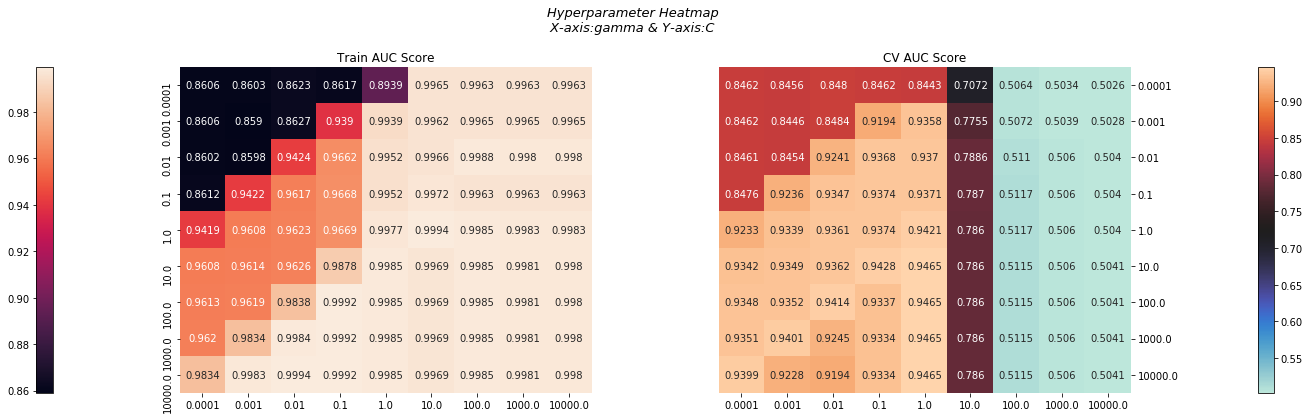

In [52]:
# Train vs CV auc score

# Reshaping auc score to form a 2D matrix
cv_auc = np.array(cv_auc).reshape(9,9)
train_auc = np.array(train_auc).reshape(9,9)

# X and Y axis
X = np.logspace(-4,4,9)
Y = np.logspace(-4,4,9)

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)

sns.heatmap(train_auc,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False, xticklabels=X, yticklabels=Y)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)

sns.heatmap(cv_auc, annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False, xticklabels=X, yticklabels=Y)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)

plt.suptitle("Hyperparameter Heatmap\n X-axis:gamma & Y-axis:C ", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

In [45]:
optimal_C,optimal_gamma

(10.0, 1.0)

In [30]:
# Converting auc score for each parameter into to 2D matrix to indentify optimal hyperparameter.
# train_auc_matrix = np.array(train_auc).reshape(9,9)
# using CV score to evaluate hyperparameter
cv_auc_matrix = np.array(cv_auc).reshape(9,9)
index = cv_auc_matrix.argmax()
optimal_C = parameters['C'][math.floor(index/9)]
optimal_gamma = parameters['gamma'][index%9]

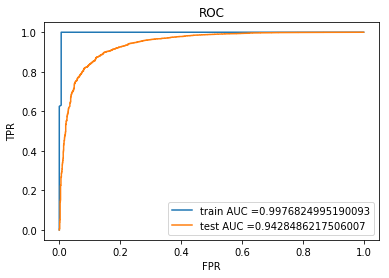

In [46]:
# Testing accuracy on test dataset
clf = SVC(C=optimal_C, gamma=optimal_gamma)
clf.fit(X_train_bow, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_bow, y_train)

predTest  = model.predict_proba(X_test_bow)
predTrain = model.predict_proba(X_train_bow)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

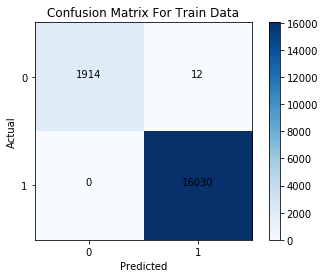

In [49]:
# Confusion Matrix
confusionMatrixPlot(y_train,model.predict(X_train_bow),"Confusion Matrix For Train Data")

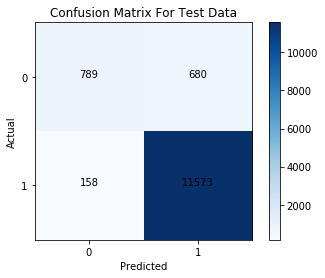

In [51]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_bow),"Confusion Matrix For Test Data")

#### Feature Engineering
    - Adding review length as a extra feature.

In [30]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_bow_newF = sparse.hstack((X_train_bow,reviewLen))
X_train_bow_newF = preprocessing.normalize(X_train_bow_newF)

print("Old Dimension: "+str(X_train_bow.shape))
print("New Dimension: "+ str(X_train_bow_newF.shape))

Old Dimension: (17956, 10116)
New Dimension: (17956, 10117)


In [31]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_bow_newF = sparse.hstack((X_test_bow,reviewLen))
X_test_bow_newF = preprocessing.normalize(X_test_bow_newF)
print("Old Dimension: "+str(X_test_bow.shape))
print("New Dimension: "+ str(X_test_bow_newF.shape))

Old Dimension: (13200, 10116)
New Dimension: (13200, 10117)


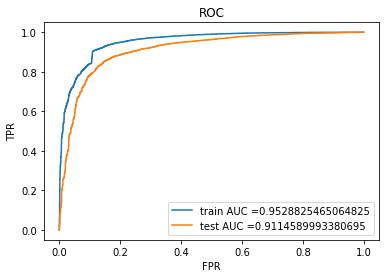

In [36]:
# Testing accuracy on test dataset
clf = SVC(C=optimal_C, gamma=optimal_gamma)
clf.fit(X_train_bow_newF, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_bow_newF, y_train)

predTest  = model.predict_proba(X_test_bow_newF)
predTrain = model.predict_proba(X_train_bow_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

#### Observation: 
    - Accuracy drops by 3% when review legth is added as a extra feature. 
    - less overfit after adding review length as a extra feature.
    - From training confusion matrix we can see that the RBF kernel clearly separates negative reviews and only 12 positive reviews were incorrectly classified. i.e. model is overfitting as during testing accuracy drops to 94%.

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [56]:
# TFIDF Vectorization
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train_tfidf.shape)

X_cv_tfidf = vectorizer.transform(X_CVText)
X_cv_tfidf = preprocessing.normalize(X_cv_tfidf)
print("CV Data Size:    ",X_cv_tfidf.shape)

X_test_tfidf = vectorizer.transform(X_testText)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size:  ",X_train_tfidf.shape)

Train Data Size:  (17956, 10170)
CV Data Size:     (8844, 10170)
Test Data Size:   (17956, 10170)


In [48]:
# Model Training
parameters = {"C": np.logspace(-4,4,9),
              "gamma": np.logspace(-4,4,9)} 
train_auc = []
cv_auc = []
Optimal_hp = {'bestScore':0, 'C': 0, 'gamma':0}

for i in tqdm(parameters['C']):
    for j in parameters['gamma']:
        clf = SVC(C=i , gamma=j)
        clf.fit(X_train_tfidf, y_train)
        
        model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
        model.fit(X_train_tfidf, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  model.predict_proba(X_train_tfidf)[:,1]
        y_cv_pred =  model.predict_proba(X_cv_tfidf)[:,1]
        
        # training score
        trainScore = roc_auc_score(y_train,y_train_pred)
        train_auc.append(trainScore)
        
         # CV score
        cvScore = roc_auc_score(y_cv, y_cv_pred)
        cv_auc.append(cvScore)
        
        # Updating best score for each hyperparameter
        if cvScore > Optimal_hp['bestScore']:
            Optimal_hp['bestScore'] = cvScore
            # index of best hyperparameters
            Optimal_hp['C'] = i
            Optimal_hp['gamma'] = j

print("C: "+str(Optimal_hp['C']))
print("gamma: "+str(Optimal_hp['gamma']))


100%|██████████| 9/9 [10:57:09<00:00, 5595.87s/it] 


C: 10.0
gamma: 1.0


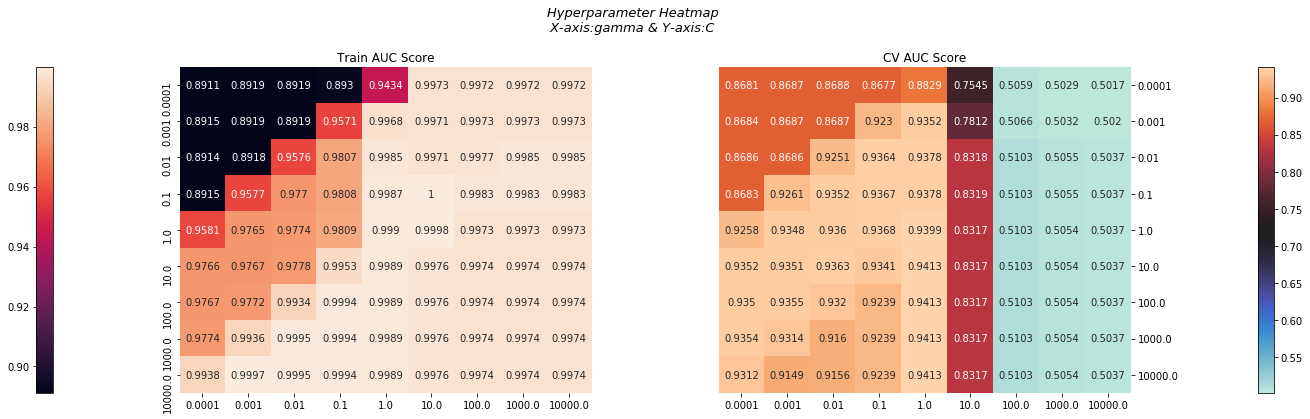

In [54]:
# Train vs CV auc score

# Reshaping auc score to form a 2D matrix
cv_auc = np.array(cv_auc).reshape(9,9)
train_auc = np.array(train_auc).reshape(9,9)

# X and Y axis
X = np.logspace(-4,4,9)
Y = np.logspace(-4,4,9)

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)

sns.heatmap(train_auc,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False, xticklabels=X, yticklabels=Y)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)

sns.heatmap(cv_auc, annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False, xticklabels=X, yticklabels=Y)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)

plt.suptitle("Hyperparameter Heatmap\n X-axis:gamma & Y-axis:C ", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

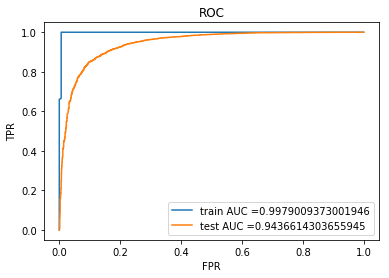

In [57]:
# Testing accuracy on test dataset
clf = SVC(C=Optimal_hp['C'], gamma=Optimal_hp['gamma'])
clf.fit(X_train_tfidf, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_tfidf, y_train)

predTest  = model.predict_proba(X_test_tfidf)
predTrain = model.predict_proba(X_train_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

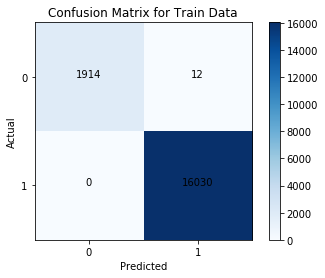

In [58]:
# Confusion Matrix
confusionMatrixPlot(y_train,model.predict(X_train_tfidf),"Confusion Matrix for Train Data")

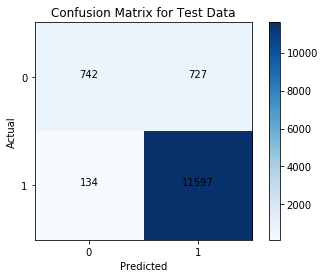

In [59]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_tfidf),"Confusion Matrix for Test Data")

#### Feature Engineering

In [38]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_tfidf_newF = sparse.hstack((X_train_tfidf,reviewLen))
X_train_tfidf_newF = preprocessing.normalize(X_train_tfidf_newF)
print("Old Dimension: "+str(X_train_tfidf.shape))
print("New Dimension: "+ str(X_train_tfidf_newF.shape))

Old Dimension: (17956, 10116)
New Dimension: (17956, 10117)


In [39]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_tfidf_newF = sparse.hstack((X_test_tfidf,reviewLen))
X_test_tfidf_newF = preprocessing.normalize(X_test_tfidf_newF)
print("Old Dimension: "+str(X_test_bow.shape))
print("New Dimension: "+ str(X_test_tfidf_newF.shape))

Old Dimension: (13200, 10116)
New Dimension: (13200, 10117)


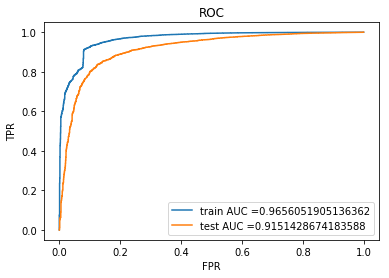

In [40]:
# Testing accuracy on test dataset
clf = SVC(C=Optimal_hp['C'], gamma=Optimal_hp['gamma'])
clf.fit(X_train_tfidf_newF, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_tfidf_newF, y_train)

predTest  = model.predict_proba(X_test_tfidf_newF)
predTrain = model.predict_proba(X_train_tfidf_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

#### Observation
    - Accuracy drops by 2% with TFIDF when review length is added as a extra feature.
    - After adding review length as a feature overfit is less.
    - Again from training conclusion matrix we can say that model is overfiting.

# [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [63]:
# Train your own Word2Vec model using your own text corpus
def sentenceSplit(data):
    list_of_sentance=[]
    for sentance in data:
        list_of_sentance.append(sentance.split())
    return list_of_sentance

In [64]:
# this line of code trains your w2v model on the give list of sentances
list_of_sentance_train = sentenceSplit(X_trainText)
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=150, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [65]:
def avgW2V(list_of_sentance,W2VModel):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(150) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in W2VModel:
                vec = W2VModel.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors


In [66]:
# Vectorizing Train and Test data
# Training Data
X_train_w2v = avgW2V(list_of_sentance_train, w2v_model)

# CV Data
list_of_sentance_cv = sentenceSplit(X_CVText)
X_cv_w2v = avgW2V(list_of_sentance_cv, w2v_model)

# Test Data
list_of_sentance_test = sentenceSplit(X_testText)
X_test_w2v = avgW2V(list_of_sentance_test, w2v_model)

100%|██████████| 13200/13200 [00:06<00:00, 2061.58it/s]


In [17]:
# Model Training
parameters = {"C": np.logspace(-4,4,9),
              "gamma": np.logspace(-4,4,9)} 
train_auc = []
cv_auc = []
Optimal_hp = {'bestScore':0, 'C': 0, 'gamma':0}

for i in tqdm(parameters['C']):
    for j in parameters['gamma']:
        clf = SVC(C=i , gamma=j)
        clf.fit(X_train_w2v, y_train)
        
        model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
        model.fit(X_train_w2v, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  model.predict_proba(X_train_w2v)[:,1]
        y_cv_pred =  model.predict_proba(X_cv_w2v)[:,1]
        
        # training score
        trainScore = roc_auc_score(y_train,y_train_pred)
        train_auc.append(trainScore)
        
         # CV score
        cvScore = roc_auc_score(y_cv, y_cv_pred)
        cv_auc.append(cvScore)
        
        # Updating best score for each hyperparameter
        if cvScore > Optimal_hp['bestScore']:
            Optimal_hp['bestScore'] = cvScore
            # index of best hyperparameters
            Optimal_hp['C'] = i
            Optimal_hp['gamma'] = j

print("C: "+str(Optimal_hp['C']))
print("gamma: "+str(Optimal_hp['gamma']))

100%|██████████| 9/9 [6:58:23<00:00, 3690.47s/it]  

C: 1000.0
gamma: 0.0001


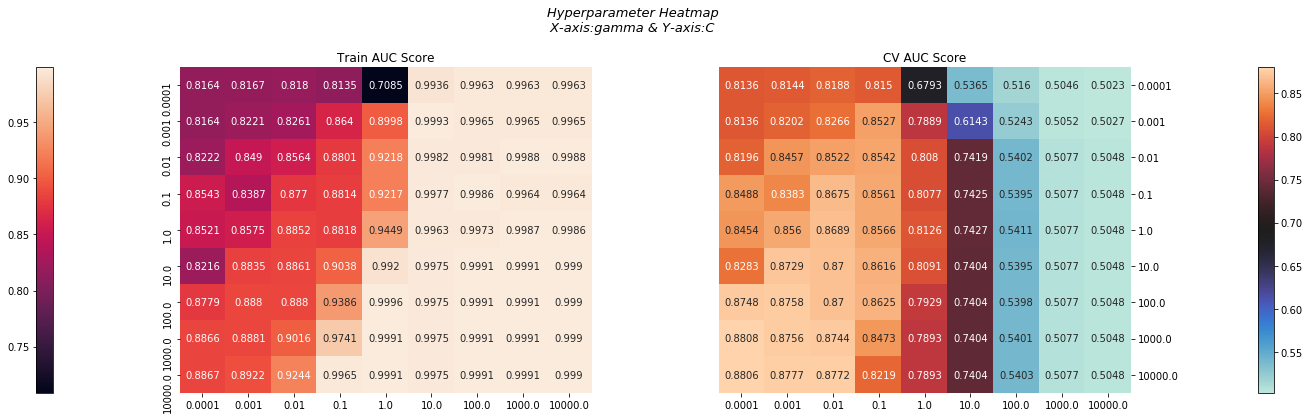

In [61]:
# Train vs CV auc score

# Reshaping auc score to form a 2D matrix
cv_auc = np.array(cv_auc).reshape(9,9)
train_auc = np.array(train_auc).reshape(9,9)

# X and Y axis
X = np.logspace(-4,4,9)
Y = np.logspace(-4,4,9)

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)

sns.heatmap(train_auc,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False, xticklabels=X, yticklabels=Y)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)

sns.heatmap(cv_auc, annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False, xticklabels=X, yticklabels=Y)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)

plt.suptitle("Hyperparameter Heatmap\n X-axis:gamma & Y-axis:C ", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

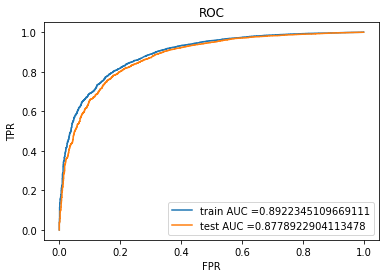

In [67]:
# Testing accuracy on test dataset
clf = SVC(C=Optimal_hp['C'], gamma=Optimal_hp['gamma'])
clf.fit(X_train_w2v, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_w2v, y_train)

predTest  = model.predict_proba(X_test_w2v)
predTrain = model.predict_proba(X_train_w2v)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

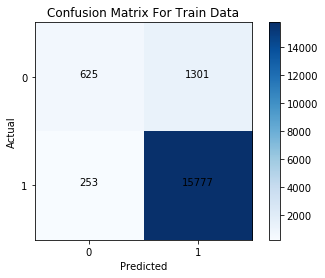

In [68]:
# Confusion Matrix
confusionMatrixPlot(y_train, model.predict(X_train_w2v), "Confusion Matrix For Train Data")

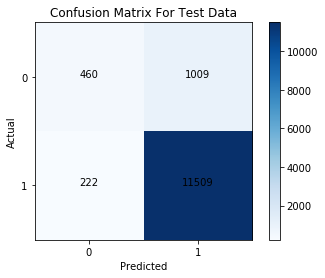

In [69]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_w2v), "Confusion Matrix For Test Data")

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [72]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_trainText:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_testText:
    sent_of_test.append(sent.split()) 
    
sent_of_cv = []
for sent in X_CVText:
    sent_of_cv.append(sent.split())

In [73]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_AW2V.append(sent_vec)
    row += 1


100%|██████████| 17956/17956 [04:18<00:00, 69.38it/s]


In [74]:
# TFIDF-Word2Vec for CV data.
X_cv_tfidf = vectorizer.transform(X_CVText)
X_cv_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_cv): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_cv_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidf_AW2V.append(sent_vec)
    row += 1


100%|██████████| 8844/8844 [02:11<00:00, 67.34it/s]


In [75]:
# TFIDF-Word2Vec for test data .
X_test_tfidf_AW2V = []; 
X_test_tfidf = vectorizer.transform(X_testText)
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_AW2V.append(sent_vec)
    row += 1


100%|██████████| 13200/13200 [03:06<00:00, 70.66it/s]


In [76]:
X_train_tfidf_AW2V = preprocessing.normalize(X_train_tfidf_AW2V)
X_cv_tfidf_AW2V = preprocessing.normalize(X_cv_tfidf_AW2V)
X_test_tfidf_AW2V = preprocessing.normalize(X_test_tfidf_AW2V)

In [46]:
# Model Training
parameters = {"C": np.logspace(-4,4,9),
              "gamma": np.logspace(-4,4,9)} 
train_auc = []
cv_auc = []
Optimal_hp = {'bestScore':0, 'C': 0, 'gamma':0}

for i in tqdm(parameters['C']):
    for j in parameters['gamma']:
        clf = SVC(C=i , gamma=j)
        clf.fit(X_train_tfidf_AW2V, y_train)
        
        model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
        model.fit(X_train_tfidf_AW2V, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  model.predict_proba(X_train_tfidf_AW2V)[:,1]
        y_cv_pred =  model.predict_proba(X_cv_tfidf_AW2V)[:,1]
        
        # training score
        trainScore = roc_auc_score(y_train,y_train_pred)
        train_auc.append(trainScore)
        
         # CV score
        cvScore = roc_auc_score(y_cv, y_cv_pred)
        cv_auc.append(cvScore)
        
        # Updating best score for each hyperparameter
        if cvScore > Optimal_hp['bestScore']:
            Optimal_hp['bestScore'] = cvScore
            # index of best hyperparameters
            Optimal_hp['C'] = i
            Optimal_hp['gamma'] = j

print("C: "+str(Optimal_hp['C']))
print("gamma: "+str(Optimal_hp['gamma']))

100%|██████████| 9/9 [5:52:57<00:00, 3127.72s/it]  

C: 10000.0
gamma: 0.001


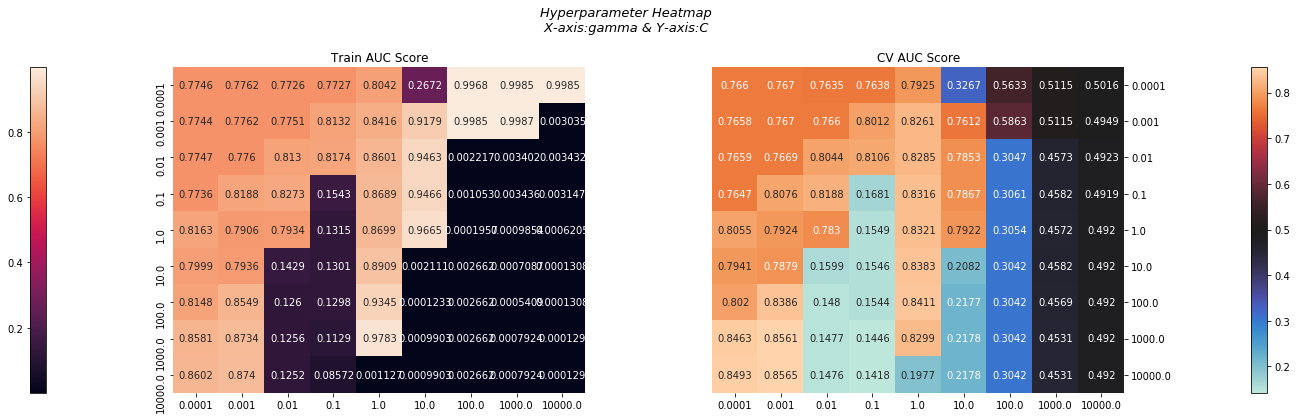

In [71]:
# Train vs CV auc score

# Reshaping auc score to form a 2D matrix
cv_auc = np.array(cv_auc).reshape(9,9)
train_auc = np.array(train_auc).reshape(9,9)

# X and Y axis
X = np.logspace(-4,4,9)
Y = np.logspace(-4,4,9)

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)

sns.heatmap(train_auc,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False, xticklabels=X, yticklabels=Y)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)

sns.heatmap(cv_auc, annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False, xticklabels=X, yticklabels=Y)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)

plt.suptitle("Hyperparameter Heatmap\n X-axis:gamma & Y-axis:C ", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

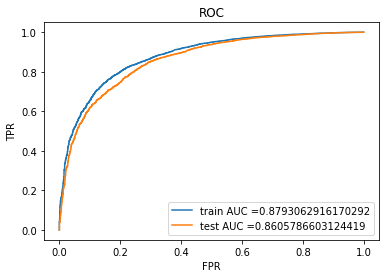

In [77]:
# Testing accuracy on test dataset
clf = SVC(C=Optimal_hp['C'], gamma=Optimal_hp['gamma'])
clf.fit(X_train_tfidf_AW2V, y_train)
model = CalibratedClassifierCV(base_estimator=clf ,cv='prefit')
model.fit(X_train_tfidf_AW2V, y_train)

predTest  = model.predict_proba(X_test_tfidf_AW2V)
predTrain = model.predict_proba(X_train_tfidf_AW2V)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

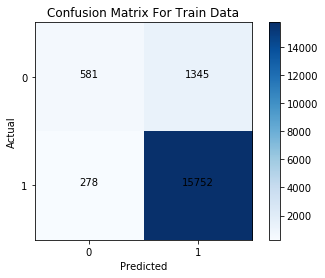

In [78]:
# Confusion Matrix
confusionMatrixPlot(y_train, model.predict(X_train_tfidf_AW2V), "Confusion Matrix For Train Data")

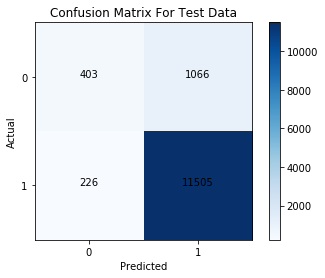

In [79]:
# Confusion Matrix
confusionMatrixPlot(y_test, model.predict(X_test_tfidf_AW2V), "Confusion Matrix For Test Data")

# [6] Conclusions

#### Conclusion table for Linear SVM

In [73]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model","Penalty", "Hyperparameter: Alpha", "AUC"]
x.add_row(["BOW", "Linear SVM","L1",0.0001, 0.9223])
x.add_row(["BOW", "Linear SVM","L2",0.0001, 0.9454])

x.add_row(["TFIDF", "Linear SVM","L1", 0.0001,0.9242 ])
x.add_row(["TFIDF", "Linear SVM","L2", 0.0001, 0.9519])

x.add_row(["Average W2v","Linear SVM","L1",0.0001,0.8925 ])
x.add_row(["Average W2v","Linear SVM","L2",0.0001, 0.8871])

x.add_row(["TFIDF-W2v", "Linear SVM","L1", 0.0001, 0.8721])
x.add_row(["TFIDF-W2v", "Linear SVM","L2", 0.0001,0.8732])
print(x)

+-------------+------------+---------+-----------------------+--------+
|  Vectorizer |   Model    | Penalty | Hyperparameter: Alpha |  AUC   |
+-------------+------------+---------+-----------------------+--------+
|     BOW     | Linear SVM |    L1   |         0.0001        | 0.9223 |
|     BOW     | Linear SVM |    L2   |         0.0001        | 0.9454 |
|    TFIDF    | Linear SVM |    L1   |         0.0001        | 0.9242 |
|    TFIDF    | Linear SVM |    L2   |         0.0001        | 0.9519 |
| Average W2v | Linear SVM |    L1   |         0.0001        | 0.8925 |
| Average W2v | Linear SVM |    L2   |         0.0001        | 0.8871 |
|  TFIDF-W2v  | Linear SVM |    L1   |         0.0001        | 0.8721 |
|  TFIDF-W2v  | Linear SVM |    L2   |         0.0001        | 0.8732 |
+-------------+------------+---------+-----------------------+--------+


#### Conclusion table for RBF SVM

In [82]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter: C, gamma", "AUC"]
x.add_row(["BOW", "RBF SVM","10, 1",0.9428])
x.add_row(["TFIDF", "RBF SVM","10, 1" , 0.9436])
x.add_row(["Average W2v","RBF SVM","1000, 0.0001", 0.8778])
x.add_row(["TFIDF-W2v", "RBF SVM","10000, 0.001",0.8605 ])
print(x)

+-------------+---------+--------------------------+--------+
|  Vectorizer |  Model  | Hyperparameter: C, gamma |  AUC   |
+-------------+---------+--------------------------+--------+
|     BOW     | RBF SVM |          10, 1           | 0.9428 |
|    TFIDF    | RBF SVM |          10, 1           | 0.9436 |
| Average W2v | RBF SVM |       1000, 0.0001       | 0.8778 |
|  TFIDF-W2v  | RBF SVM |       10000, 0.001       | 0.8605 |
+-------------+---------+--------------------------+--------+
